<font size="5">
 <div class="alert alert-block alert-info"> <b> Objetivo 3 - Modelo DNN | avg milk price consumer <b>
     </div>
</font>

      
    
  <font size="4"> MCD - Análise de Séries Temporais e Previsão </font>
  

    
  <font size="3">ISCTE-IUL </font>

<font size="4"> **Agenda** </font>  
  
- Imports and Defines
  - Imports
  - Define Function
- Model Optimization
  - Data Pre-processing
  - Optuna Function Definition
  - Model Training
  - Results
- Cross-validation
  - Data Pre-processing
  - Model Training & Results
- DNN Model Forecast
  - Data Pre-processing
  - Model Training
  - Results

# Imports and Defines

## Imports

In [156]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error as mae, mean_absolute_percentage_error as mape, mean_squared_error as mse
import keras
from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

early_stopping_rounds = keras.callbacks.EarlyStopping(monitor='loss', patience=20)

## Define Function

In [ ]:
def clean_data():
    """Lê e limpa os dados iniciais."""
    df = pd.read_csv("../data/data_avg_milk_price_consumer.csv")
    df = df.rename(columns={'observation_date': 'Date', 'APU0000709112': 'Value'})
    df = df.dropna()
    df.set_index('Date', drop=True, inplace=True)
    df.index = pd.to_datetime(df.index)
    df = df.truncate(before='1995-01', after='2023-03')
    return df['Value']

def create_sequences(train_data_sc, val_data_sc, test_data_sc, lookback, horizon):
    """Cria sequências X e y a partir de um array de dados escalados."""
    
    X_train, y_train = [], []

    for i in range(0, len(train_data_sc) - lookback - horizon + 1):
        X_train.append(train_data_sc[i:i+lookback])
        y_train.append(train_data_sc[i+lookback:i+lookback+horizon])

    X_val = val_data_sc[:lookback]
    y_val = val_data_sc[lookback:lookback + horizon].reshape(1, -1)
    
    X_test = test_data_sc[:lookback].reshape(1, -1)
    y_test = test_data_sc[lookback:lookback + horizon].reshape(1, -1)

    X_train, y_train, X_val, y_val, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_val).reshape(1, -1), np.array(y_val).reshape(1, -1), np.array(X_test).reshape(1, -1), np.array(y_test).reshape(1, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test

def create_sequences_cv(train_data_sc, val_data_sc, lookback, horizon):
    """Creates X and y sequences from scaled data arrays."""
    X_train, y_train, X_val, y_val = [], [], [], []
    
    # For training data
    for i in range(len(train_data_sc) - lookback - horizon + 1):
        X_train.append(train_data_sc[i:(i + lookback)])
        y_train.append(train_data_sc[(i + lookback):(i + lookback + horizon)])
    
    # For validation data
    for i in range(len(val_data_sc) - lookback - horizon + 1):
        X_val.append(val_data_sc[i:(i + lookback)])
        y_val.append(val_data_sc[(i + lookback):(i + lookback + horizon)])

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    
    return X_train, y_train, X_val, y_val

def standardize_data(train_data, val_data, test_data):
    """Ajusta o scaler nos dados de treino diferenciados e transforma ambos."""
    train_data = train_data.reshape(-1, 1)
    val_data = val_data.reshape(-1, 1)
    test_data = test_data.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data_sc = scaler.fit_transform(train_data).squeeze()
    val_data_sc = scaler.transform(val_data).squeeze()
    test_data_sc = scaler.transform(test_data).squeeze()
    return train_data_sc, val_data_sc, test_data_sc, scaler

def standardize_data_cv(train_data, test_data):
    """Ajusta o scaler nos dados de treino diferenciados e transforma ambos."""
    train_data = train_data.reshape(-1, 1)
    test_data = test_data.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data_sc = scaler.fit_transform(train_data).squeeze()
    test_data_sc = scaler.transform(test_data).squeeze()
    return train_data_sc, test_data_sc, scaler

def build_model(input_shape, horizon, learning_date):
    """Constrói a arquitetura do modelo LSTM."""
    model = Sequential([
        Input(input_shape),
        LSTM(units=64, kernel_initializer=keras.initializers.RandomNormal(seed=235)),
        Dense(horizon)
    ])
    
    # Reduzir learning rate
    model.compile(optimizer=Adam(learning_rate=learning_date),
                 loss='mae',
                 metrics=['mape'])
    return model

def train(X_train, y_train, model, batch_size, epochs, validation_data, early_stopping_patience=20):
    """Treina o modelo e retorna o histórico."""
    early_stopping_rounds = keras.callbacks.EarlyStopping(
        monitor='val_loss', # Monitora a perda na validação
        patience=early_stopping_patience,
        restore_best_weights=True # Restaura os pesos da melhor época
    )
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=validation_data,
        verbose=0,
        callbacks=[early_stopping_rounds]
    )
    return history

def plot_history(history, i):
    """Plota as métricas do histórico de treino e validação no mesmo gráfico."""
    if history is None or not hasattr(history, 'history') or not history.history:
        print("Nenhum histório de treino disponível ou vazio.")
        return
    
    metrics = history.history.keys()  # Obtém as métricas disponíveis no histórico

    # Verifica se há métricas de treino e validação
    if 'loss' in metrics or 'val_loss' in metrics:
        plt.figure(figsize=(12, 5))

        # Gráfico de Loss (Perda)
        if 'loss' in metrics:
            plt.subplot(1, 2, 1)
            plt.plot(history.history['loss'], label='Training Loss (MAE)')
        if 'val_loss' in metrics:
            plt.plot(history.history['val_loss'], label='Validation Loss (MAE)')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Gráfico de MAPE (Erro Médio Percentual Absoluto)
        if 'mae' in metrics or 'val_mae' in metrics:
            plt.subplot(1, 2, 2)
            if 'mae' in metrics:
                plt.plot(history.history['mae'], label='Training MAE')
            if 'val_mae' in metrics:
                plt.plot(history.history['val_mae'], label='Validation MAE')
            plt.title('Model MAE')
            plt.xlabel('Epoch')
            plt.ylabel('MAE')
            plt.legend()
            
        # Ajusta o layout e exibe os gráficos
        plt.tight_layout()
        plt.savefig(fname=f'graph_{i}')
        plt.show()
    else:
        print("Nenhuma métrica de treino ou validação encontrada no histórico.")



# Model Optimization

## Data Pre-processing

In [158]:
# --- Parâmetros ---
LOOKBACK = 30
HORIZON = 12
EPOCHS = 50
EARLY_STOPPING_PATIENCE = 15

data_original = clean_data()

train_data =  data_original.iloc[:-2*HORIZON+1].values
val_data =  data_original.iloc[-LOOKBACK-2*HORIZON:-HORIZON].values
test_data =  data_original.iloc[-(LOOKBACK+HORIZON):].values

train_data_sc, val_data_sc, test_data_sc, scaler = standardize_data(train_data, val_data, test_data)

X_train, y_train, X_val, y_val, X_test, y_test = create_sequences(train_data_sc, val_data_sc, test_data_sc, LOOKBACK, HORIZON)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (269, 30, 1)
y_train shape: (269, 12)
X_val shape: (1, 30, 1)
y_val shape: (1, 12)
X_test shape: (1, 30, 1)
y_test shape: (1, 12)


## Optuna Function Definition

In [159]:
early_stopping_rounds = keras.callbacks.EarlyStopping(
        monitor='val_loss', # Monitora a perda na validação
        patience=20,
        restore_best_weights=True # Restaura os pesos da melhor época
    )

def run(trial):
    space = {
        'batch_size': trial.suggest_categorical('batch_size', [8, 16, 32, 64, 128]),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1)
    }

    model = Sequential([
        Input(shape=(LOOKBACK, 1)),
        LSTM(units=64, activation='relu'),
        Dense(units=HORIZON)
    ])

    # Compiling the RNN
    model.compile(loss='mae', optimizer=Adam(learning_rate=space['learning_rate']))

    model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=space['batch_size'], callbacks=[early_stopping_rounds], verbose=0)

    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred).flatten()
    y_true = scaler.inverse_transform(y_val).flatten()
    
    mae_result = mae(y_true, y_pred)
    
    return mae_result

## Model Training

In [160]:
%%time
study = optuna.create_study(direction='minimize')
study.optimize(run, n_trials=50)

[I 2025-05-23 17:56:29,679] A new study created in memory with name: no-name-9b8dd1c7-aaf5-48b7-aad4-131cdae11241


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


[I 2025-05-23 17:56:40,083] Trial 0 finished with value: 0.2070459815661111 and parameters: {'batch_size': 16, 'learning_rate': 0.030790702608578645}. Best is trial 0 with value: 0.2070459815661111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


[I 2025-05-23 17:56:50,688] Trial 1 finished with value: 0.21055095561345427 and parameters: {'batch_size': 16, 'learning_rate': 0.057794524423243405}. Best is trial 0 with value: 0.2070459815661111.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


[I 2025-05-23 17:57:08,241] Trial 2 finished with value: 0.19508785867691036 and parameters: {'batch_size': 64, 'learning_rate': 0.008512080846673254}. Best is trial 2 with value: 0.19508785867691036.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


[I 2025-05-23 17:57:17,515] Trial 3 finished with value: 0.15308579889933258 and parameters: {'batch_size': 8, 'learning_rate': 0.06675426156391834}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


[I 2025-05-23 17:57:25,673] Trial 4 finished with value: 0.24603461503982527 and parameters: {'batch_size': 128, 'learning_rate': 0.028260352848890218}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


[I 2025-05-23 17:57:33,330] Trial 5 finished with value: 0.158916660785675 and parameters: {'batch_size': 16, 'learning_rate': 0.015205339372708397}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


[I 2025-05-23 17:57:40,548] Trial 6 finished with value: 0.4336667938232419 and parameters: {'batch_size': 16, 'learning_rate': 0.05548469144264134}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


[I 2025-05-23 17:58:00,248] Trial 7 finished with value: 0.28326657136281336 and parameters: {'batch_size': 8, 'learning_rate': 0.021194606551511418}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


[I 2025-05-23 17:58:08,165] Trial 8 finished with value: 0.16494914754231768 and parameters: {'batch_size': 32, 'learning_rate': 0.024673848747869796}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


[I 2025-05-23 17:58:17,331] Trial 9 finished with value: 0.21221861855188992 and parameters: {'batch_size': 64, 'learning_rate': 0.018465382834997438}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


[I 2025-05-23 17:58:26,255] Trial 10 finished with value: 0.6123068812688189 and parameters: {'batch_size': 8, 'learning_rate': 0.08852630987746678}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


[I 2025-05-23 17:58:36,416] Trial 11 finished with value: 0.2286005489031474 and parameters: {'batch_size': 8, 'learning_rate': 0.0777707133298565}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


[I 2025-05-23 17:58:43,339] Trial 12 finished with value: 0.2596673491795859 and parameters: {'batch_size': 128, 'learning_rate': 0.07341531026724775}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


[I 2025-05-23 17:58:52,309] Trial 13 finished with value: 0.16761484607060748 and parameters: {'batch_size': 32, 'learning_rate': 0.041976493233867124}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


[I 2025-05-23 17:59:03,460] Trial 14 finished with value: 0.19777036571502682 and parameters: {'batch_size': 8, 'learning_rate': 0.06461408742125237}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


[I 2025-05-23 17:59:14,581] Trial 15 finished with value: 0.20761188729604083 and parameters: {'batch_size': 16, 'learning_rate': 0.002228313240650955}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


[I 2025-05-23 17:59:25,927] Trial 16 finished with value: 0.21398344866434746 and parameters: {'batch_size': 8, 'learning_rate': 0.09646916398950434}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


[I 2025-05-23 17:59:36,308] Trial 17 finished with value: 0.2661380236943563 and parameters: {'batch_size': 16, 'learning_rate': 0.04177699757519162}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


[I 2025-05-23 17:59:44,353] Trial 18 finished with value: 0.1854007932345071 and parameters: {'batch_size': 64, 'learning_rate': 0.04337237134229942}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


[I 2025-05-23 17:59:51,407] Trial 19 finished with value: 0.30858492088317885 and parameters: {'batch_size': 32, 'learning_rate': 0.067273003584327}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


[I 2025-05-23 17:59:57,343] Trial 20 finished with value: 0.6499514072736102 and parameters: {'batch_size': 128, 'learning_rate': 0.08557740492008342}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


[I 2025-05-23 18:00:07,351] Trial 21 finished with value: 0.1719919131596883 and parameters: {'batch_size': 32, 'learning_rate': 0.012373770779848014}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


[I 2025-05-23 18:00:13,892] Trial 22 finished with value: 0.19338564729690552 and parameters: {'batch_size': 32, 'learning_rate': 0.03070813905759715}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


[I 2025-05-23 18:00:20,592] Trial 23 finished with value: 0.1585001190503437 and parameters: {'batch_size': 32, 'learning_rate': 0.0024961387778765012}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


[I 2025-05-23 18:00:29,322] Trial 24 finished with value: 0.19476633135477697 and parameters: {'batch_size': 32, 'learning_rate': 0.009765625080886296}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


[I 2025-05-23 18:00:39,526] Trial 25 finished with value: 0.205385117371877 and parameters: {'batch_size': 16, 'learning_rate': 0.0017202886683942618}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


[I 2025-05-23 18:00:51,101] Trial 26 finished with value: 0.2650777371724447 and parameters: {'batch_size': 8, 'learning_rate': 0.013577189071276589}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


[I 2025-05-23 18:00:58,039] Trial 27 finished with value: 0.3437576376597084 and parameters: {'batch_size': 32, 'learning_rate': 0.03559008249535998}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


[I 2025-05-23 18:01:11,524] Trial 28 finished with value: 0.18324016396204626 and parameters: {'batch_size': 16, 'learning_rate': 0.04758505060389015}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


[I 2025-05-23 18:01:21,038] Trial 29 finished with value: 0.17228556966781602 and parameters: {'batch_size': 8, 'learning_rate': 0.03493551962228354}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


[I 2025-05-23 18:01:32,186] Trial 30 finished with value: 0.2705789728164674 and parameters: {'batch_size': 16, 'learning_rate': 0.05544625478106194}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


[I 2025-05-23 18:01:40,212] Trial 31 finished with value: 0.20119413661956773 and parameters: {'batch_size': 32, 'learning_rate': 0.02281791391218309}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


[I 2025-05-23 18:01:53,084] Trial 32 finished with value: 0.21364365736643476 and parameters: {'batch_size': 32, 'learning_rate': 0.005518703126277525}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


[I 2025-05-23 18:02:03,489] Trial 33 finished with value: 0.20605797497431422 and parameters: {'batch_size': 32, 'learning_rate': 0.017273311878956664}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


[I 2025-05-23 18:02:10,596] Trial 34 finished with value: 0.17398592487970974 and parameters: {'batch_size': 64, 'learning_rate': 0.026536574820101515}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


[I 2025-05-23 18:02:16,435] Trial 35 finished with value: 0.1968588428497313 and parameters: {'batch_size': 128, 'learning_rate': 0.008077755298062081}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


[I 2025-05-23 18:02:24,588] Trial 36 finished with value: 0.17885361766815186 and parameters: {'batch_size': 32, 'learning_rate': 0.06015626762314174}. Best is trial 3 with value: 0.15308579889933258.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


[I 2025-05-23 18:02:32,436] Trial 37 finished with value: 0.15206393893559758 and parameters: {'batch_size': 16, 'learning_rate': 0.015012366192982771}. Best is trial 37 with value: 0.15206393893559758.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


[I 2025-05-23 18:02:40,270] Trial 38 finished with value: 0.16357376829783107 and parameters: {'batch_size': 16, 'learning_rate': 0.01587935635517953}. Best is trial 37 with value: 0.15206393893559758.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


[I 2025-05-23 18:02:48,586] Trial 39 finished with value: 0.23024589665730774 and parameters: {'batch_size': 16, 'learning_rate': 0.07232123781711308}. Best is trial 37 with value: 0.15206393893559758.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


[I 2025-05-23 18:02:56,744] Trial 40 finished with value: 0.2493929587999981 and parameters: {'batch_size': 16, 'learning_rate': 0.05210641406362208}. Best is trial 37 with value: 0.15206393893559758.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


[I 2025-05-23 18:03:10,662] Trial 41 finished with value: 0.21577229817708335 and parameters: {'batch_size': 16, 'learning_rate': 0.017829641401523565}. Best is trial 37 with value: 0.15206393893559758.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


[I 2025-05-23 18:03:19,121] Trial 42 finished with value: 0.18738890345891315 and parameters: {'batch_size': 16, 'learning_rate': 0.014286333632405702}. Best is trial 37 with value: 0.15206393893559758.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


[I 2025-05-23 18:03:27,313] Trial 43 finished with value: 0.20327952162424723 and parameters: {'batch_size': 16, 'learning_rate': 0.005850443311029671}. Best is trial 37 with value: 0.15206393893559758.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


[I 2025-05-23 18:03:35,071] Trial 44 finished with value: 0.14985220495859777 and parameters: {'batch_size': 16, 'learning_rate': 0.021933294118963664}. Best is trial 44 with value: 0.14985220495859777.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


[I 2025-05-23 18:03:45,485] Trial 45 finished with value: 0.20313992818196616 and parameters: {'batch_size': 16, 'learning_rate': 0.022417755292800105}. Best is trial 44 with value: 0.14985220495859777.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


[I 2025-05-23 18:03:55,788] Trial 46 finished with value: 0.19867897748947147 and parameters: {'batch_size': 8, 'learning_rate': 0.010503010278531962}. Best is trial 44 with value: 0.14985220495859777.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


[I 2025-05-23 18:04:09,085] Trial 47 finished with value: 0.20863811826705933 and parameters: {'batch_size': 64, 'learning_rate': 0.0011020208607705336}. Best is trial 44 with value: 0.14985220495859777.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


[I 2025-05-23 18:04:17,023] Trial 48 finished with value: 0.22146593252817792 and parameters: {'batch_size': 16, 'learning_rate': 0.029038910593586674}. Best is trial 44 with value: 0.14985220495859777.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


[I 2025-05-23 18:04:26,974] Trial 49 finished with value: 0.21414801200230918 and parameters: {'batch_size': 8, 'learning_rate': 0.019069466898453666}. Best is trial 44 with value: 0.14985220495859777.


CPU times: total: 13min 1s
Wall time: 7min 57s


## Results

In [ ]:
study.best_params
#0.021933294118963664

{'batch_size': 16, 'learning_rate': 0.021933294118963664}

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_21420\1753676737.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study);


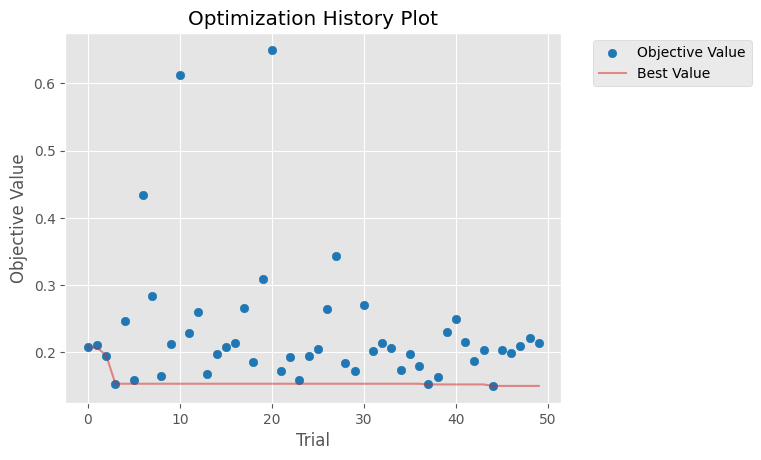

In [162]:
plot_optimization_history(study);

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_21420\2122237422.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study);


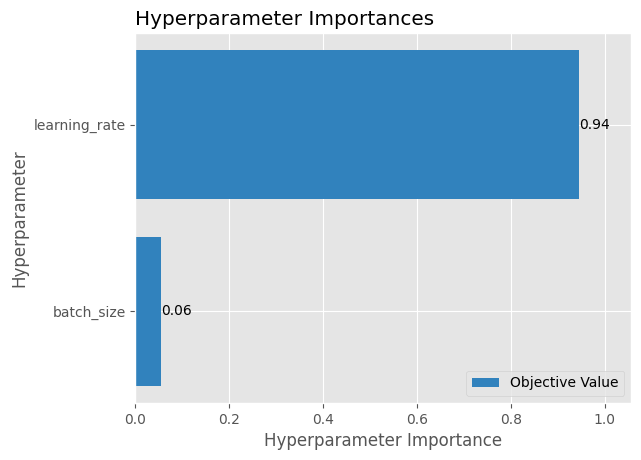

In [163]:
plot_param_importances(study);

# Cross-validation

## Data Pre-processing

In [164]:
# --- Parâmetros ---
LOOKBACK = 30
HORIZON = 12
BATCH_SIZE = 8
N_SPLITS = 7
EPOCHS = 50
EARLY_STOPPING_PATIENCE = 15
LEARNING_RATE = study.best_params['learning_rate']

data_original = clean_data()
print(f"Tamanho dados originais: {len(data_original)}")

tscv = TimeSeriesSplit(n_splits=N_SPLITS, max_train_size=LOOKBACK+HORIZON*5, test_size=LOOKBACK+HORIZON, gap=-LOOKBACK)

fold_mae_orig = []
fold_mape_orig = []

Tamanho dados originais: 333


## Model Training & Results


===== Fold 1/7 =====
  Índices Treino: 0 a 68 (Tamanho: 69)
  Índices Teste: 39 a 80 (Tamanho: 42)
  Formato X_train: (28, 30), y_train: (28, 12)
  Formato X_val: (1, 30), y_val: (1, 12)


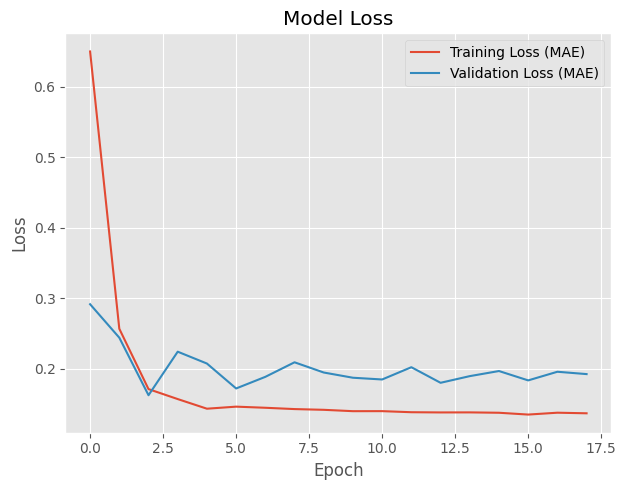

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step

--- Métricas de Erro (Escala Original) ---
Prediction for 12 Months/Year: MAE = 0.08845 (3.053%)
Prediction for 3 Months/Year: MAE = 0.07838 (2.723%)
Prediction for 1 Month/Year: MAE = 0.1 (3.515%)

===== Fold 2/7 =====
  Índices Treino: 21 a 110 (Tamanho: 90)
  Índices Teste: 81 a 122 (Tamanho: 42)
  Formato X_train: (49, 30), y_train: (49, 12)
  Formato X_val: (1, 30), y_val: (1, 12)


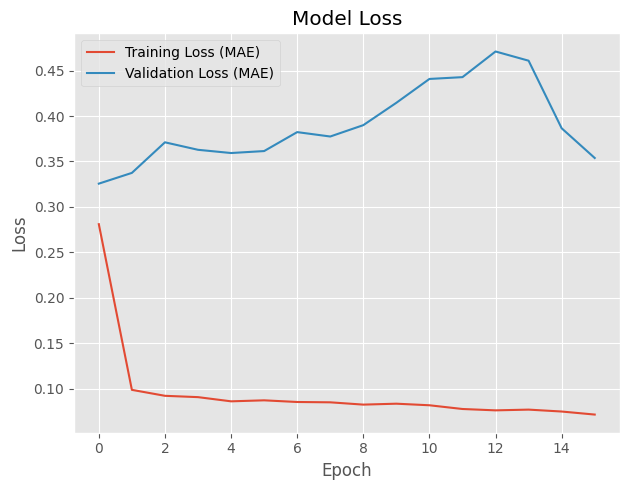

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step

--- Métricas de Erro (Escala Original) ---
Prediction for 12 Months/Year: MAE = 0.3389 (10.59%)
Prediction for 3 Months/Year: MAE = 0.2965 (9.236%)
Prediction for 1 Month/Year: MAE = 0.2246 (7.105%)

===== Fold 3/7 =====
  Índices Treino: 63 a 152 (Tamanho: 90)
  Índices Teste: 123 a 164 (Tamanho: 42)
  Formato X_train: (49, 30), y_train: (49, 12)
  Formato X_val: (1, 30), y_val: (1, 12)


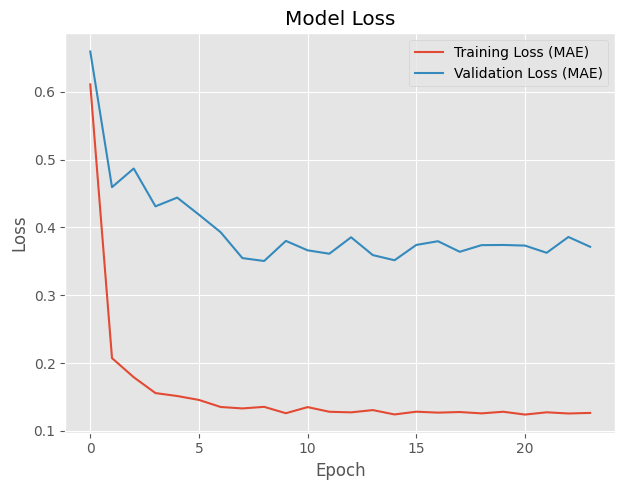

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step

--- Métricas de Erro (Escala Original) ---
Prediction for 12 Months/Year: MAE = 0.4374 (11.75%)
Prediction for 3 Months/Year: MAE = 0.4173 (11.05%)
Prediction for 1 Month/Year: MAE = 0.3991 (10.51%)

===== Fold 4/7 =====
  Índices Treino: 105 a 194 (Tamanho: 90)
  Índices Teste: 165 a 206 (Tamanho: 42)
  Formato X_train: (49, 30), y_train: (49, 12)
  Formato X_val: (1, 30), y_val: (1, 12)


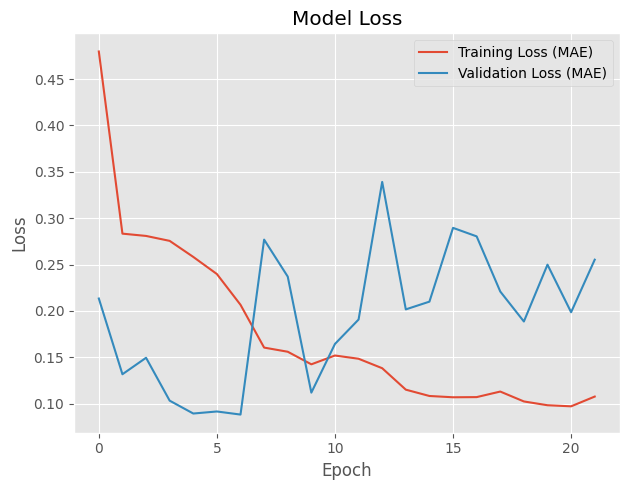

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step

--- Métricas de Erro (Escala Original) ---
Prediction for 12 Months/Year: MAE = 0.09304 (2.676%)
Prediction for 3 Months/Year: MAE = 0.01113 (0.3107%)
Prediction for 1 Month/Year: MAE = 0.01065 (0.294%)

===== Fold 5/7 =====
  Índices Treino: 147 a 236 (Tamanho: 90)
  Índices Teste: 207 a 248 (Tamanho: 42)
  Formato X_train: (49, 30), y_train: (49, 12)
  Formato X_val: (1, 30), y_val: (1, 12)


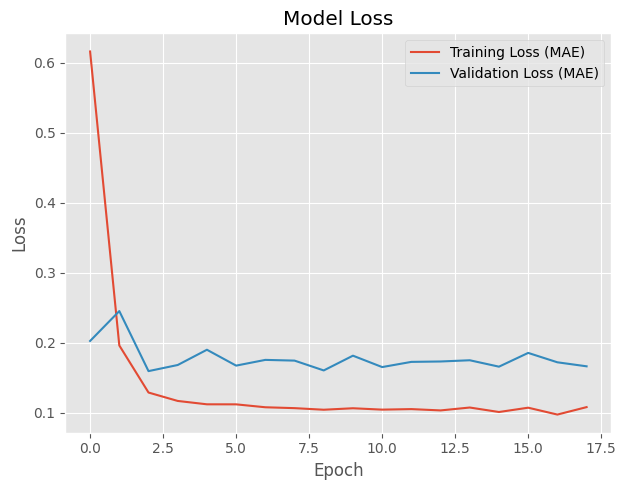

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step

--- Métricas de Erro (Escala Original) ---
Prediction for 12 Months/Year: MAE = 0.1567 (4.758%)
Prediction for 3 Months/Year: MAE = 0.07053 (2.084%)
Prediction for 1 Month/Year: MAE = 0.05628 (1.657%)

===== Fold 6/7 =====
  Índices Treino: 189 a 278 (Tamanho: 90)
  Índices Teste: 249 a 290 (Tamanho: 42)
  Formato X_train: (49, 30), y_train: (49, 12)
  Formato X_val: (1, 30), y_val: (1, 12)


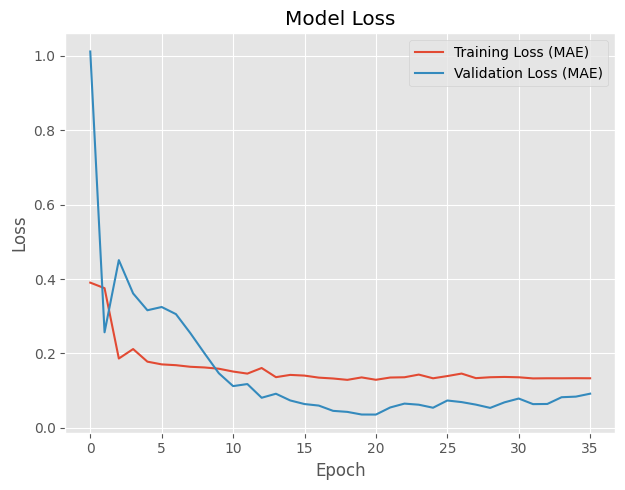

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step

--- Métricas de Erro (Escala Original) ---
Prediction for 12 Months/Year: MAE = 0.03633 (1.231%)
Prediction for 3 Months/Year: MAE = 0.04585 (1.593%)
Prediction for 1 Month/Year: MAE = 0.04906 (1.684%)

===== Fold 7/7 =====
  Índices Treino: 231 a 320 (Tamanho: 90)
  Índices Teste: 291 a 332 (Tamanho: 42)
  Formato X_train: (49, 30), y_train: (49, 12)
  Formato X_val: (1, 30), y_val: (1, 12)


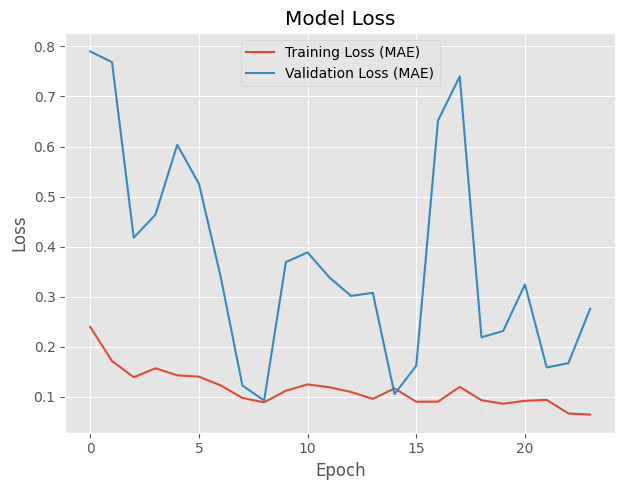

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step

--- Métricas de Erro (Escala Original) ---
Prediction for 12 Months/Year: MAE = 0.09952 (2.392%)
Prediction for 3 Months/Year: MAE = 0.1078 (2.586%)
Prediction for 1 Month/Year: MAE = 0.02769 (0.6903%)

===== Avaliação Média dos Testes nos Folds =====
MAE Médio Teste (escala original): 0.1786 +/- 0.1389
MAPE Médio Teste (escala original): 5.2070% +/- 3.9052%


In [165]:
for fold, (train_index, val_index) in enumerate(tscv.split(data_original.values)):
    print(f"\n===== Fold {fold + 1}/{N_SPLITS} =====")
    print(f"  Índices Treino: {train_index[0]} a {train_index[-1]} (Tamanho: {len(train_index)})")
    print(f"  Índices Teste: {val_index[0]} a {val_index[-1]} (Tamanho: {len(val_index)})")

    train_data =  data_original.iloc[train_index].values
    val_data =  data_original.iloc[val_index].values
    
    train_data_sc, val_data_sc, scaler = standardize_data_cv(train_data, val_data)
    
    X_train, y_train, X_val, y_val = create_sequences_cv(train_data_sc, val_data_sc, LOOKBACK, HORIZON)

    print(f"  Formato X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"  Formato X_val: {X_val.shape}, y_val: {y_val.shape}")
    
    model = build_model(input_shape=(LOOKBACK, 1), horizon=HORIZON, learning_date=LEARNING_RATE)
    
    history = train(X_train, y_train, model,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                    early_stopping_patience=EARLY_STOPPING_PATIENCE)

    plot_history(history, fold)

    y_pred = model.predict(X_val) # Saída é (1, HORIZON)
    y_pred = scaler.inverse_transform(y_pred).flatten()

    y_true = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

    mae_12_months = mae(y_true, y_pred)
    mape_12_months = mape(y_true, y_pred)
    mae_3_months = mae(y_true[:3], y_pred[:3])
    mape_3_months = mape(y_true[:3], y_pred[:3])
    mae_1_month = mae([y_true[0]], [y_pred[0]])
    mape_1_month = mape([y_true[0]], [y_pred[0]])


    fold_mae_orig.append(mae_12_months)
    fold_mape_orig.append(mape_12_months)
    
    print(f"\n--- Métricas de Erro (Escala Original) ---")
    print(f"Prediction for 12 Months/Year: MAE = {mae_12_months:.4} ({mape_12_months*100:.4}%)")
    print(f"Prediction for 3 Months/Year: MAE = {mae_3_months:.4} ({mape_3_months*100:.4}%)")
    print(f"Prediction for 1 Month/Year: MAE = {mae_1_month:.4} ({mape_1_month*100:.4}%)")

# --- Avaliação Média da Validação Cruzada (Resultados de Teste) ---
print("\n===== Avaliação Média dos Testes nos Folds =====")
if fold_mae_orig:
    print(f"MAE Médio Teste (escala original): {np.mean(fold_mae_orig):.4f} +/- {np.std(fold_mae_orig):.4f}")
    print(f"MAPE Médio Teste (escala original): {np.mean(fold_mape_orig)*100:.4f}% +/- {np.std(fold_mape_orig)*100:.4f}%")
else:
    print("Nenhum fold completou o teste com sucesso.")

# DNN Model Forecast

## Data Pre-processing

In [166]:
# --- Parâmetros ---
LOOKBACK = 30
HORIZON = 12
BATCH_SIZE = 8
N_SPLITS = 5
EPOCHS = 50
EARLY_STOPPING_PATIENCE = 15

data_original = clean_data()

train_data =  data_original.iloc[:-2*HORIZON+1].values
val_data =  data_original.iloc[-LOOKBACK-2*HORIZON:-HORIZON].values
test_data =  data_original.iloc[-(LOOKBACK+HORIZON):].values

train_data_sc, val_data_sc, test_data_sc, scaler = standardize_data(train_data, val_data, test_data)

X_train, y_train, X_val, y_val, X_test, y_test = create_sequences(train_data_sc, val_data_sc, test_data_sc, LOOKBACK, HORIZON)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (269, 30, 1)
y_train shape: (269, 12)
X_val shape: (1, 30, 1)
y_val shape: (1, 12)
X_test shape: (1, 30, 1)
y_test shape: (1, 12)


## Model Training

In [275]:
keras.utils.set_random_seed(31)

early_stopping_rounds = keras.callbacks.EarlyStopping(
        monitor='val_loss', # Monitora a perda na validação
        patience=20,
        restore_best_weights=True # Restaura os pesos da melhor época
        
    )

model = Sequential([
    Input(shape=(LOOKBACK, 1)),
    LSTM(units=64, activation='relu'),
    Dense(units=HORIZON)
])

    # Compiling the RNN
model.compile(loss='mae', optimizer=Adam(learning_rate=LEARNING_RATE))

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, callbacks=[early_stopping_rounds])

y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred).flatten()
y_true = scaler.inverse_transform(y_test).flatten()

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 4.6206 - val_loss: 0.2812
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1626 - val_loss: 0.2427
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1192 - val_loss: 0.1695
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1180 - val_loss: 0.1744
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1116 - val_loss: 0.1741
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1076 - val_loss: 0.1783
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1035 - val_loss: 0.1822
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1009 - val_loss: 0.1891
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0989 - val_loss: 0.2053
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0966 - val_loss: 0.2099
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0953 - val_loss: 0.2209
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

## Results

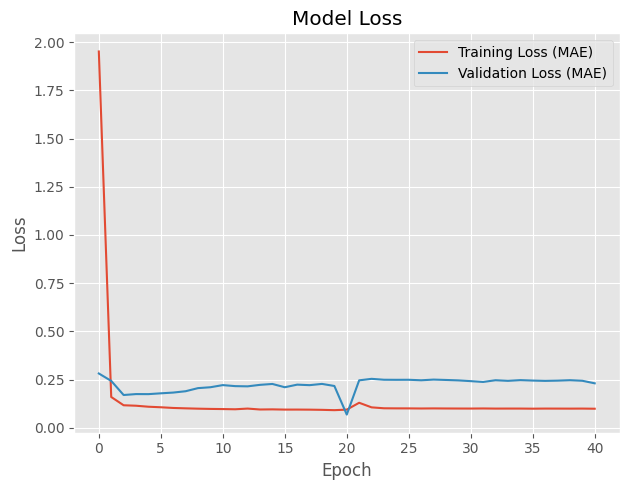

In [276]:
plot_history(history, 1)

In [277]:
mae_12_months = mae(y_true, y_pred)
mape_12_months = mape(y_true, y_pred)

mae_3_months = mae(y_true[0:3], y_pred[0:3])
mape_3_months = mape(y_true[0:3], y_pred[0:3])

mae_1_month = mae([y_true[0]], [y_pred[0]])
mape_1_month = mape([y_true[0]], [y_pred[0]])

print(f"Prediction for 12 Months/Year: MAE = {mae_12_months:.4} ({mape_12_months*100:.4}%)")
print(f"Prediction for 3 Months/Year: MAE = {mae_3_months:.4} ({mape_3_months*100:.4}%)")
print(f"Prediction for 1 Month/Year: MAE = {mae_1_month:.4} ({mape_1_month*100:.4}%)")

Prediction for 12 Months/Year: MAE = 0.1703 (4.071%)
Prediction for 3 Months/Year: MAE = 0.08322 (1.989%)
Prediction for 1 Month/Year: MAE = 0.006092 (0.1518%)


In [278]:
forecast_out_sample = y_pred
forecast_in_sample = scaler.inverse_transform(model.predict(X_val)).flatten()

real_train = data_original.iloc[:-12].values.flatten()
real_test = data_original.iloc[-12:].values.flatten()

index = data_original.iloc[-12:].index
errors = real_test - forecast_out_sample

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_21420\1870870529.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-o" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot(index, forecast_out_sample, 'k-o',color='skyblue', label='Predicted value')


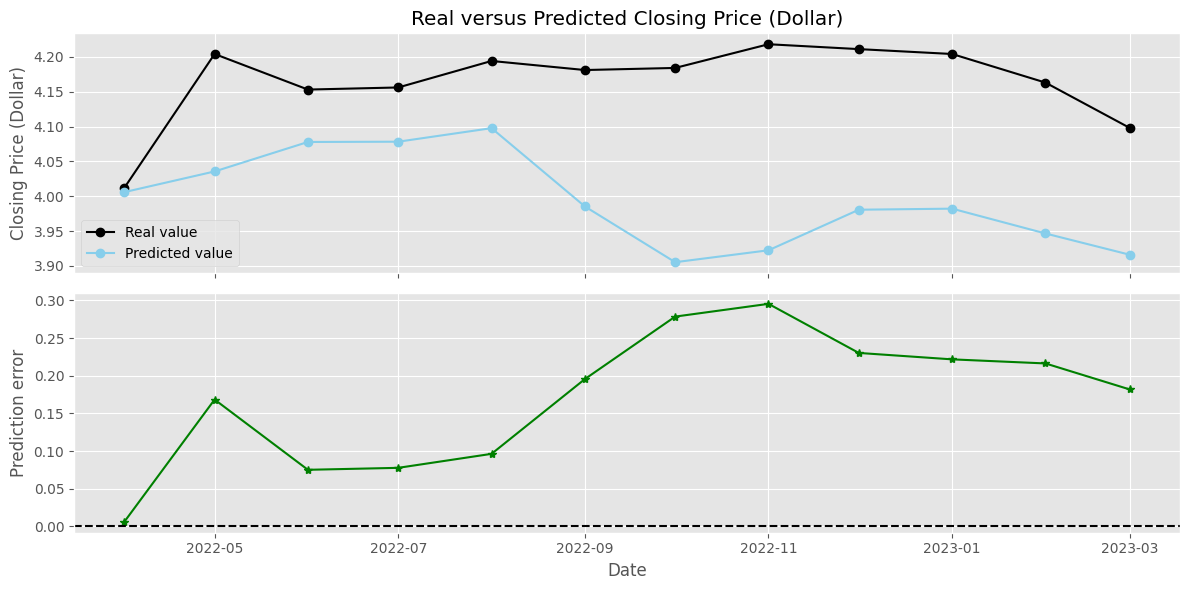

In [279]:
# Plot
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# 1. Real vs Previsão
axs[0].plot(index, real_test, 'k-o', label='Real value')
axs[0].plot(index, forecast_out_sample, 'k-o',color='skyblue', label='Predicted value')
axs[0].set_title('Real versus Predicted Closing Price (Dollar)')
axs[0].set_ylabel('Closing Price (Dollar)')
axs[0].legend()
axs[0].grid(True)

# 2. Erros
axs[1].plot(index, errors, 'g-*')
axs[1].axhline(y=0, linestyle='--', color='k')
axs[1].set_ylabel('Prediction error')
axs[1].set_xlabel('Date')
axs[1].grid(True)

plt.tight_layout()
plt.show()

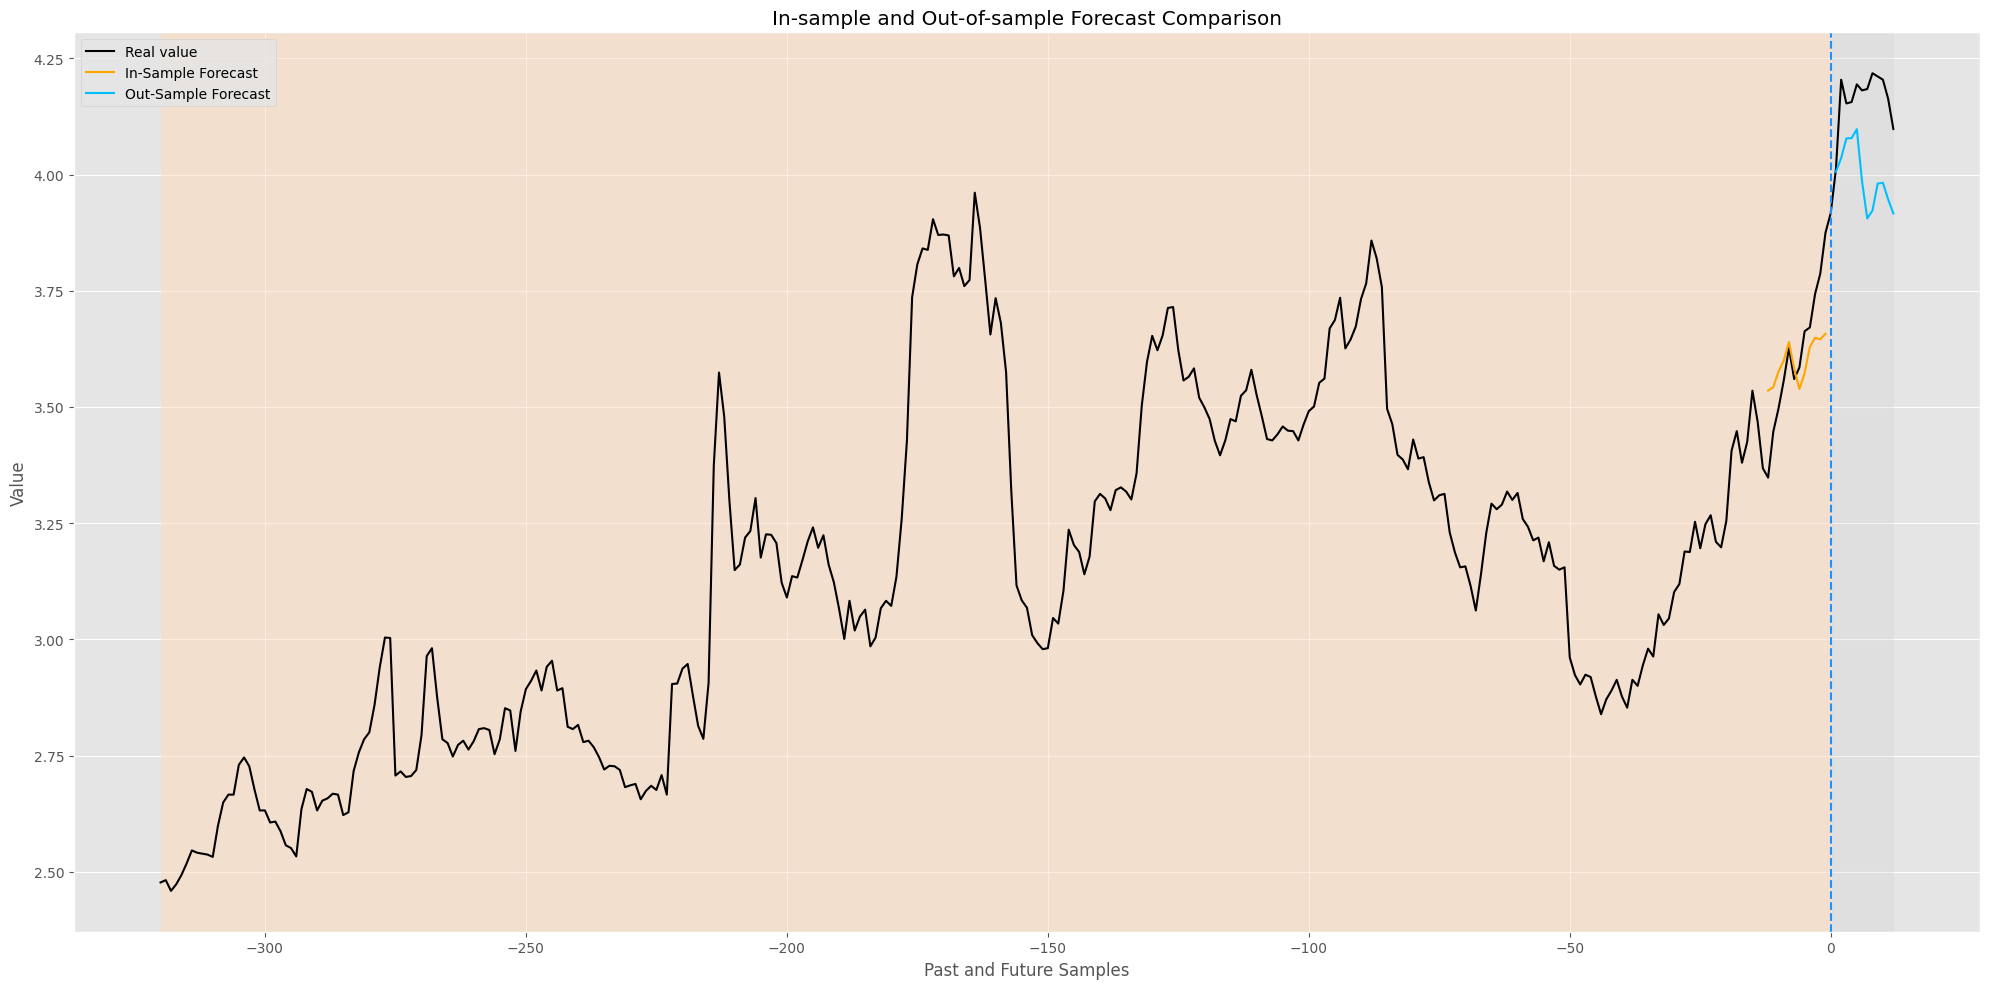

In [280]:
# Construção do eixo temporal artificial
x_real = np.arange(-(len(data_original)-12) + 1, 12 + 1)
x_in_sample = np.arange(-len(forecast_in_sample), 0)
x_out_sample = np.arange(1, len(forecast_out_sample) + 1)

# Gráfico
plt.figure(figsize=(20, 10))
plt.title('In-sample and Out-of-sample Forecast Comparison')

# Série real (linha preta)
plt.plot(x_real, np.concatenate([real_train, real_test]), 'k-', label='Real value')

# Previsões
plt.plot(x_in_sample, forecast_in_sample, color='orange', label='In-Sample Forecast')
plt.plot(x_out_sample, forecast_out_sample, color='deepskyblue', label='Out-Sample Forecast')

# Destaques visuais
plt.axvspan(x_real[0], 0, color='peachpuff', alpha=0.5)   # zona treino
plt.axvspan(0, x_real[-1], color='lightgray', alpha=0.3)  # zona teste
plt.axvline(0, color='dodgerblue', linestyle='--')       # divisão treino/teste

plt.xlabel('Past and Future Samples')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
